In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# Data Import

In [151]:
df = pd.read_csv("Project_1_Data.csv")

# Data Analysis & Visualization

In [152]:
df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       860 non-null    float64
 1   Y       860 non-null    float64
 2   Z       860 non-null    float64
 3   Step    860 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 27.0 KB


,X,Y,Z,Step
count,860.000000,860.000000,860.000000,860.000000
mean,5.587116,4.845605,1.197465,7.756977
std,3.719067,1.142329,0.522844,2.407837
min,0.000000,3.062500,0.000000,1.000000
25%,1.562500,3.062500,0.783800,7.000000
50%,7.770000,5.125000,1.220000,8.000000
75%,8.575000,5.845000,1.616975,9.000000
max,9.375000,5.845000,2.350000,13.000000


In [153]:
df["Step"].value_counts()

Step
9     251
8     221
7     148
1      24
2      24
3      24
4      24
5      24
6      24
10     24
11     24
12     24
13     24
Name: count, dtype: int64

<Axes: >

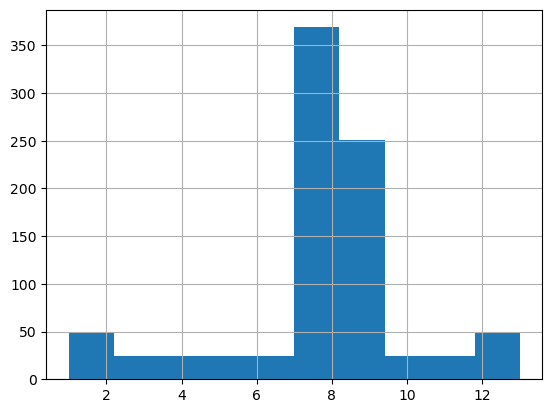

In [154]:
df["Step"].hist()

From the above, it can be seen that steps 7, 8, and 9 have more rows than the others. This could imply that these steps involve more movement/finer adjustments. In order to 
ensure all steps are proportionally represented, this will be used for the stratified sampling of the data

<Axes: >

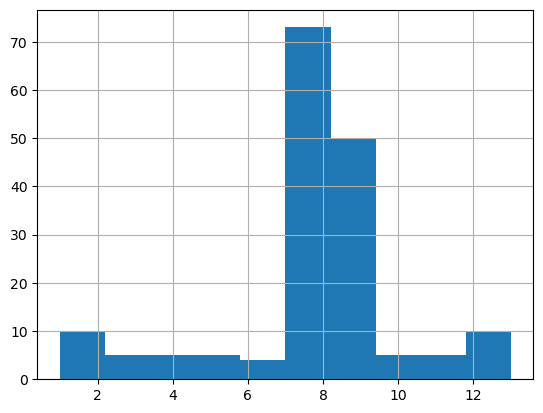

In [155]:
#Create an 80/20 train/test split

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(df, df["Step"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

test_set["Step"].hist()

In [156]:
#Create a copy of the training data for exploration
exp_set  = train_set.copy()

I would like to first visualze the range of each axis per step, to see if there are any correlations. For example, if Step 5 involves a lot of translation in the x-axis, but
minimal movement in the others

In [157]:
coord_range = exp_set.groupby('Step')[['X', 'Y', 'Z']].agg(
    X_min = ('X', 'min'),
    X_max = ('X', 'max'),
    Y_min = ('Y', 'min'),
    Y_max = ('Y', 'max'),
    Z_min = ('Z', 'min'),
    Z_max = ('Z', 'max'),
).reset_index()


coord_range

,Step,X_min,X_max,Y_min,Y_max,Z_min,Z_max
0,1,9.375,9.375,3.0625,3.0625,0.50,0.72
1,2,9.375,9.375,3.0625,3.0625,0.74,0.97
2,3,9.375,9.375,3.0625,3.0625,0.98,1.21
3,4,9.375,9.375,3.0625,3.0625,1.22,1.45
4,5,9.375,9.375,3.0625,3.0625,1.46,1.69
5,6,9.375,9.375,3.0625,3.0625,1.71,1.92
6,7,8.575,8.575,5.6250,5.6250,0.36,1.82
7,8,6.945,9.145,5.1250,5.1250,0.35,2.00
8,9,0.375,2.875,5.8450,5.8450,0.00,2.35
9,10,0.000,0.000,3.0625,3.0625,0.98,1.21


# Correlation Analysis 

In [158]:
corr_matrix = exp_set.corr()

corr_matrix["Step"].sort_values(ascending = False)

Step    1.000000
Y       0.294097
Z       0.192925
X      -0.749724
Name: Step, dtype: float64

<Axes: xlabel='Z', ylabel='Step'>

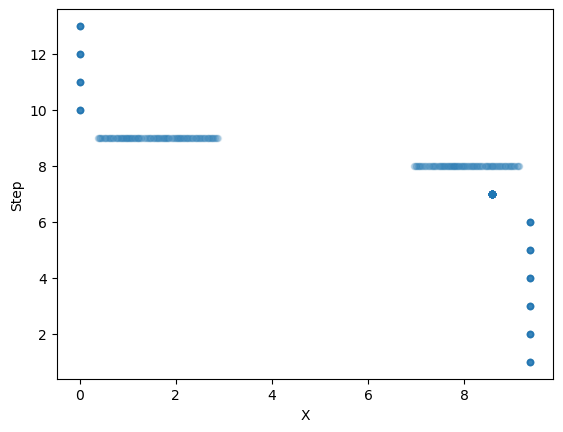

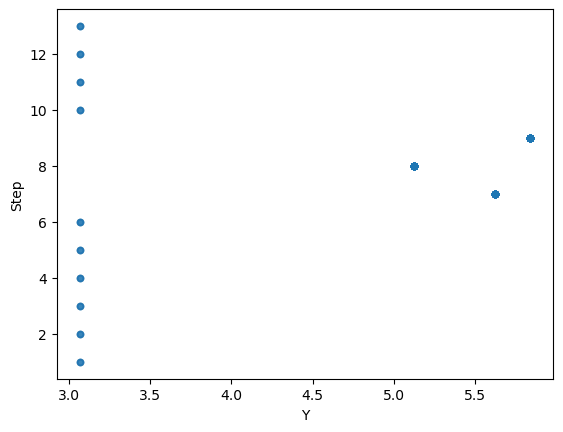

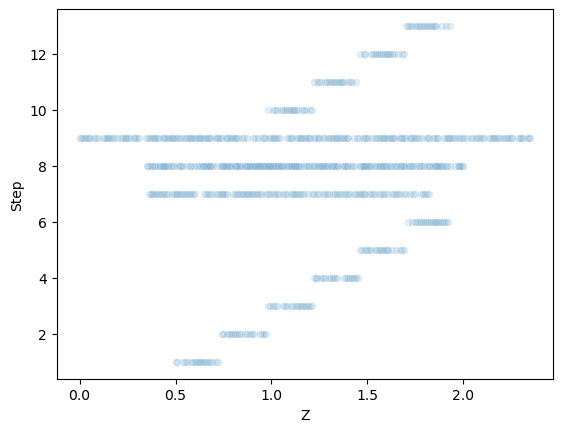

In [159]:
exp_set.plot(kind = "scatter", x = "X", y = "Step", alpha = 0.1)

exp_set.plot(kind = "scatter", x = "Y", y = "Step", alpha = 0.1)

exp_set.plot(kind = "scatter", x = "Z", y = "Step", alpha = 0.1)

# Training Data Preparation

Before performing any prepatory transformations of the datset, they first need to be split between observations and labels. A pipeline with a custom transformer is created in order to compare results of training with and without certain features. 

In [160]:
X_train = train_set.drop("Step", axis = 1)

y_train = train_set["Step"].copy()

In order to prepare the data for a training model, it first needs to be scaled, as the range of the different coordinate axes have different scales.

In [161]:
scaler = StandardScaler()

scaler.fit_transform(X_train)

array([[-1.50397952, -1.56731855,  0.78938332],
       [-1.50397952, -1.56731855,  0.36716295],
       [ 0.78272666,  0.24188724,  0.62145477],
       ...,
       [ 1.01960735, -1.56731855, -1.09141649],
       [ 0.36818546,  0.24188724, -1.59520216],
       [ 1.01960735, -1.56731855, -0.43889411]])

# Model Training

In [162]:
#Using gridsearch to train an SGDClassifier
sdg_clf = SGDClassifier()

param_grid = [
    {'max_iter': [100, 200, 300, 1000]}
]

grid_search_SGD = GridSearchCV(sdg_clf, param_grid, cv=5, scoring='accuracy')

grid_search_SGD.fit(X_train, y_train)

grid_search_SGD.best_params_

{'max_iter': 100}

In [163]:
cross_val_score(sdg_clf, X_train, y_train, cv=10, scoring='accuracy')

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [1, 2, 3]}
]

grid_search_

NameError: name 'grid_search_' is not defined

In [181]:
y_train_pred = cross_val_predict(sdg_clf, X_train, y_train, cv=5)

conf_mat = confusion_matrix(y_train, y_train_pred)

conf_mat

TypeError: cross_val_predict() got an unexpected keyword argument 'random_state'

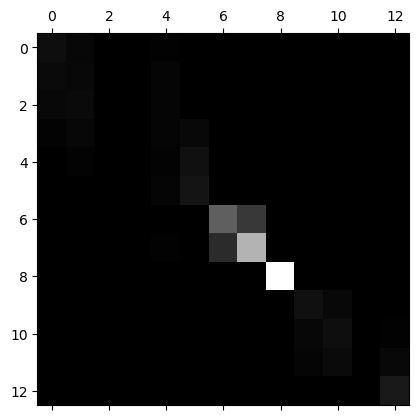

In [140]:
plt.matshow(conf_mat, cmap=plt.cm.gray)
plt.show()

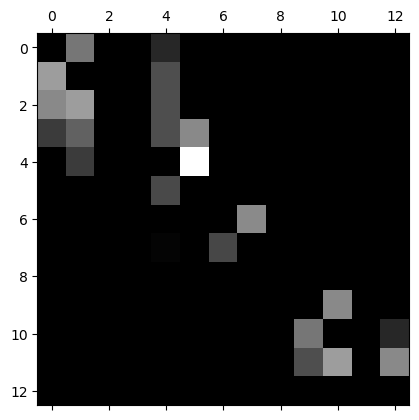

In [141]:
row_sums = conf_mat.sum(axis = 1, keepdims=True)
norm_conf_mat = conf_mat/row_sums

np.fill_diagonal(norm_conf_mat, 0)

plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()